            EDA
FER2013 Emotion Dataset for Music Recommendation System
- Input: 7 emotion classes (from FER2013)
- Output: 5 final classes (after mapping)
- Image Size: 48x48 grayscale
- Model: EfficientNet B0 (needs 224x224 RGB)


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from PIL import Image
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings("ignore")

2025-07-13 14:46:39.026753: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 14:46:39.028682: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-13 14:46:39.114090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-13 14:46:39.115485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-13 14:46:39.985562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
data_path = '/app/data/raw/fer2013'



In [3]:
# Class mapping
print("Defining class mappings:")
project_mapping = {
    'angry': 'angry',
    'disgust': 'stressed',
    'fear': 'stressed',
    'happy': 'happy',
    'sad': 'sad',
    'surprise': 'happy',
    'neutral': 'neutral'
}
print("Project-specific emotion mapping defined.\n")
print("FER2013 → Project Mapped Classes:")
for original, mapped in project_mapping.items():
    print(f"  {original:<10} → {mapped}")


final_classes = ['angry', 'happy', 'sad', 'stressed', 'neutral']
original_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

print("\n Final Classes Used in Project:", final_classes)
print("\n ")
print(" Original FER2013 Classes     :", original_classes)

Defining class mappings:
Project-specific emotion mapping defined.

FER2013 → Project Mapped Classes:
  angry      → angry
  disgust    → stressed
  fear       → stressed
  happy      → happy
  sad        → sad
  surprise   → happy
  neutral    → neutral

 Final Classes Used in Project: ['angry', 'happy', 'sad', 'stressed', 'neutral']

 
 Original FER2013 Classes     : ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
print("Checking if train and test folders exist:")
print("Train exists?", os.path.exists(os.path.join(data_path, "train")))
print("Test exists?", os.path.exists(os.path.join(data_path, "test")))

Checking if train and test folders exist:
Train exists? True
Test exists? True


In [5]:
# Class Distributions
def compute_class_distributions():
    print("Computing class distributions for FER2013")

    original_dist = {'train': defaultdict(int), 'test': defaultdict(int)}
    mapped_dist = {'train': defaultdict(int), 'test': defaultdict(int)}

    for split in ['train', 'test']:
        print(f"\nAnalyzing '{split}' set:")
        split_path = os.path.join(data_path, split)
        
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            if os.path.isdir(cls_path):
                count = len([
                    f for f in os.listdir(cls_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                
                original_dist[split][cls] += count
                mapped_cls = project_mapping.get(cls)
                if mapped_cls:
                    mapped_dist[split][mapped_cls] += count
                
                print(f"  • Found {count} images in '{cls}' → Mapped to '{mapped_cls}'")

    print("\nFinished computing class distributions.")
    return original_dist, mapped_dist

original_dist, mapped_dist = compute_class_distributions()

# summary of mapped class distributions
print("\nSummary of Mapped Class Distribution:")
for split in ['train', 'test']:
    print(f"\n{split.upper()} SET:")
    for cls, count in mapped_dist[split].items():
        print(f"  {cls:<10}: {count} images")

Computing class distributions for FER2013

Analyzing 'train' set:
  • Found 3995 images in 'angry' → Mapped to 'angry'
  • Found 436 images in 'disgust' → Mapped to 'stressed'
  • Found 4097 images in 'fear' → Mapped to 'stressed'
  • Found 7215 images in 'happy' → Mapped to 'happy'
  • Found 4965 images in 'neutral' → Mapped to 'neutral'
  • Found 4830 images in 'sad' → Mapped to 'sad'
  • Found 3171 images in 'surprise' → Mapped to 'happy'

Analyzing 'test' set:
  • Found 958 images in 'angry' → Mapped to 'angry'
  • Found 111 images in 'disgust' → Mapped to 'stressed'
  • Found 1024 images in 'fear' → Mapped to 'stressed'
  • Found 1774 images in 'happy' → Mapped to 'happy'
  • Found 1233 images in 'neutral' → Mapped to 'neutral'
  • Found 1247 images in 'sad' → Mapped to 'sad'
  • Found 831 images in 'surprise' → Mapped to 'happy'

Finished computing class distributions.

Summary of Mapped Class Distribution:

TRAIN SET:
  angry     : 3995 images
  stressed  : 4533 images
  happy  

Plotting pie chart comparison of class ratios.

 


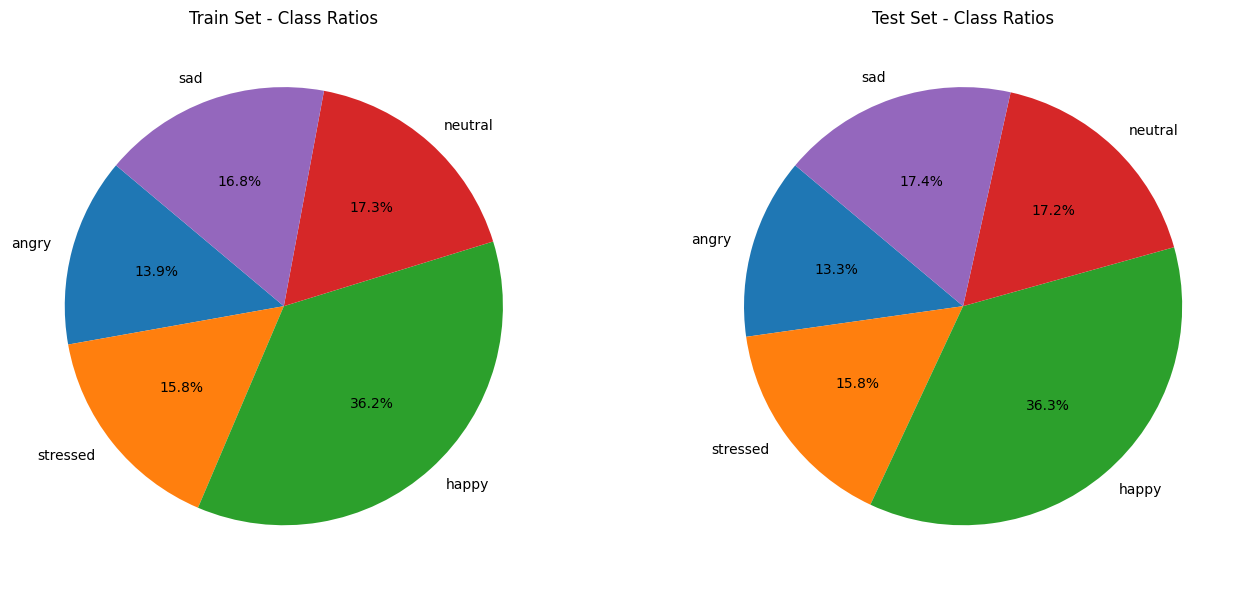

In [6]:
# Define the function
def plot_pie_comparison(mapped_dist):
    print("Plotting pie chart comparison of class ratios.")
    print("\n ")
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    for i, split in enumerate(['train', 'test']):
        data = mapped_dist[split]
        axs[i].pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140)
        axs[i].set_title(f'{split.capitalize()} Set - Class Ratios')
    plt.tight_layout()
    plt.show()

plot_pie_comparison(mapped_dist)


In [7]:
#  Corrupted Images
def check_corrupted_images(data_path):
    print("Checking for corrupted images in the dataset...")
    corrupted_files = []

    for split in ['train', 'test']:
        split_path = os.path.join(data_path, split)
        

        for emotion in os.listdir(split_path):
            emotion_path = os.path.join(split_path, emotion)

            if not os.path.isdir(emotion_path):
                continue

            for img_file in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Check if image is corrupted
                except Exception as e:
                    print(f"Corrupted: {img_path} ({str(e)})")
                    corrupted_files.append(img_path)
        print(f"Scanned {split} folder.")

    print(f"\n Total corrupted files found: {len(corrupted_files)}")
    return corrupted_files


corrupted_images = check_corrupted_images(data_path)

Checking for corrupted images in the dataset...
Scanned train folder.
Scanned test folder.

 Total corrupted files found: 0


In [8]:
# 4. Class Imbalance Ratios
def calculate_imbalance_ratios(mapped_dist):
    print("\n Calculating Class Imbalance Ratios...\n")
    imbalance_info = {}

    for split in ['train', 'test']:
        dist = mapped_dist.get(split, {})
        total = sum(dist.values())

        if total == 0:
            print(f" No data found for {split}. Skipping...")
            continue

        ratios = {cls: round((count / total) * 100, 2) for cls, count in dist.items()}
        sorted_ratios = dict(sorted(ratios.items(), key=lambda item: item[1], reverse=True))
        imbalance_info[split] = sorted_ratios

        print(f" {split.upper()} Set Ratios:")
        for cls, pct in sorted_ratios.items():
            print(f"   - {cls:<10}: {pct}%")
        print()

    return imbalance_info

imbalance_info = calculate_imbalance_ratios(mapped_dist)


 Calculating Class Imbalance Ratios...

 TRAIN Set Ratios:
   - happy     : 36.18%
   - neutral   : 17.29%
   - sad       : 16.82%
   - stressed  : 15.79%
   - angry     : 13.92%

 TEST Set Ratios:
   - happy     : 36.29%
   - sad       : 17.37%
   - neutral   : 17.18%
   - stressed  : 15.81%
   - angry     : 13.35%



Showing image augmentations...


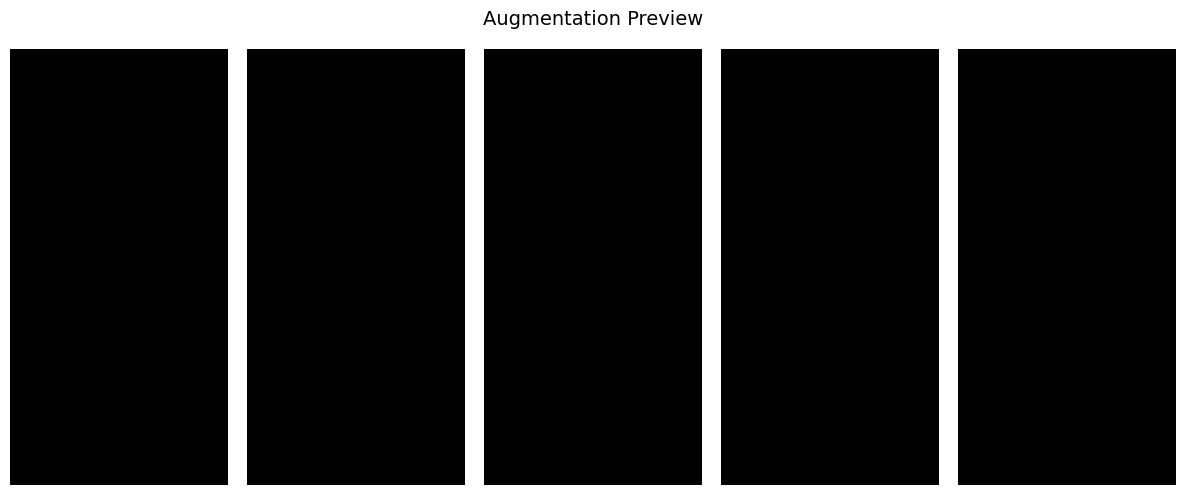

In [9]:
# 5. Augmentation Grid
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def show_augmentation_grid(sample_img):
    """
    Displays a grid of 10 augmented versions of a single grayscale 48x48 image.
    """
    print("Showing image augmentations...")

    if sample_img.shape != (48, 48):
        raise ValueError(f"Expected input shape (48, 48), got {sample_img.shape}")

    # Expand dims: (1, 48, 48, 1)
    sample_img = np.expand_dims(sample_img, axis=(0, -1)).astype('float32')
    sample_img /= 255.0  # Normalize to [0, 1]

    # Create ImageDataGenerator with augmentations
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.9, 1.1],
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Plot 10 augmentations
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
        ax = axes[i // 5, i % 5]
        ax.imshow(batch[0].reshape(48, 48), cmap='gray')
        ax.axis('off')
        if i == 9:
            break

    plt.suptitle("Augmentation Preview", fontsize=14)
    plt.tight_layout()
    plt.show()

test_img = np.random.randint(0, 256, (48, 48), dtype=np.uint8)
show_augmentation_grid(test_img)